In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
def group_data(data, window_size=96):
    """
    Separa o vetor data em pares de vetores X de entrada e valor de predição y
    data: Conjunto de dados
    window_size: Tamanho dos vetores de dados em X
    Retorna o vetor X e Y
    """
    data_X = []
    data_Y = []
    len_data = len(data)
    for i in range(len_data - window_size):
        data_X.append(data[i:i + window_size])
        data_Y.append(data[i + window_size])
    return np.array(data_X), np.array(data_Y)

In [3]:
import pandas as pd
import numpy as np
import importlib

from segmentation_algorithms.utils import *

from time import perf_counter 

try:
  importlib.reload(plot)
except:
  import plot
  importlib.reload(plot)
from plot import plot

try:
  importlib.reload(segmentation_algorithms.topdown_index)
except:
  import segmentation_algorithms.topdown_index
  importlib.reload(segmentation_algorithms.topdown_index)
from segmentation_algorithms.topdown_index import XTSTreeTopDownIndex

try:
  importlib.reload(segmentation_algorithms.topdown_reg)
except:
  import segmentation_algorithms.topdown_reg
  importlib.reload(segmentation_algorithms.topdown_reg)
from segmentation_algorithms.topdown_reg import XTSTreeTopDownReg

try:
  importlib.reload(XTSTree.XTSTreePageHinkley)
except:
  import XTSTree.XTSTreePageHinkley
  importlib.reload(XTSTree.XTSTreePageHinkley)
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley

try:
  importlib.reload(XTSTree.XTSTreeRandomCut)
except:
  import XTSTree.XTSTreeRandomCut
  importlib.reload(XTSTree.XTSTreeRandomCut)
from XTSTree.XTSTreeRandomCut import XTSTreeRandomCut

try:
  importlib.reload(XTSTree.XTSTreePeriodicCut)
except:
  import XTSTree.XTSTreePeriodicCut
  importlib.reload(XTSTree.XTSTreePeriodicCut)
from XTSTree.XTSTreePeriodicCut import XTSTreePeriodicCut

In [4]:
def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [6]:
series = np.array(pd.read_csv('./datasets/base datasets/23025122/export_automaticas_23025122_tempmedar2m.csv')['tempmedar2m'][:96*20])

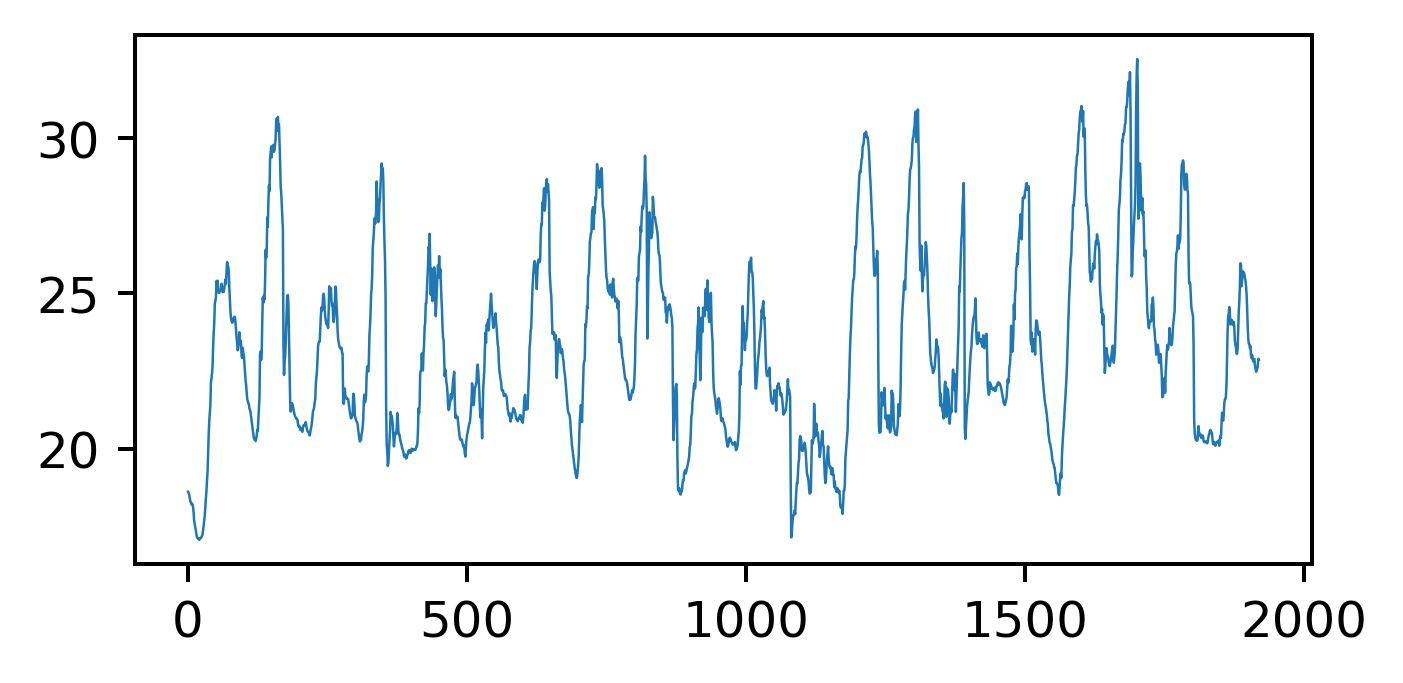

In [7]:
plot(series)

Page-Hinkley aplicado na série

In [8]:
t = perf_counter()
ph_model = XTSTreePageHinkley(stop_condition='adf', stop_val=0.5, max_iter=100, min_dist=0)
ph_model = ph_model.create_splits(series)
# plot(np.array(series), divisions=ph_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_page_hinkley = ph_model.cut_series(series)
ph_model.calculate_entropy_gain()
ph_model.calc_mean_entropy_gain_by_cut()

Não achei só um corte, escolhendo corte que gera maior pontuação, 1634, 683.5525588636692, 0, 5


(-0.8408824328772226, 12, 10)

Random cut

In [43]:
t = perf_counter()
ran_model = XTSTreeRandomCut(stop_condition='adf', stop_val=0, max_iter=100, min_dist=0)
ran_model = ran_model.create_splits(series)
# plot(np.array(series), divisions=ran_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_random = ran_model.cut_series(series)
ran_model.calculate_entropy_gain()
ran_model.calc_mean_entropy_gain_by_cut()
# for depth, val in ran_model.get_items_by_depth().items():
#   print(f'Profundidade: {depth}')
#   for content in val:
#     print(f'Posição: {content["cut_pos"]}, entropia: {content["entropy"]}, ganho: {content["entropy_gain"]}')

(-0.7730040548847837, 13, 8)

Periodic cut

In [10]:
t = perf_counter()
per_model = XTSTreePeriodicCut(stop_condition='adf', stop_val=0, max_iter=100, min_dist=0)
per_model = per_model.create_splits(series)
# plot(np.array(series), divisions=per_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_periodic = per_model.cut_series(series)
per_model.calculate_entropy_gain()
per_model.calc_mean_entropy_gain_by_cut()
# for depth, val in per_model.get_items_by_depth().items():
#   print(f'Profundidade: {depth}')
#   for content in val:
#     print(f'Posição: {content["cut_pos"]}, entropia: {content["entropy"]}, ganho: {content["entropy_gain"]}')

(-1.5893157084623926, 8, 4)

Regressão linear aplicado no índice

In [11]:
m_model, _, _, _ = apply_lr(np.arange(len(series)), series)
yhat = m_model.predict(np.arange(len(series)).reshape(-1, 1))
error = rmse(series, yhat)
# plot(series, sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdi_model = XTSTreeTopDownIndex(stop_val=2.5, max_iter=100, min_dist=0)
tdi_model = tdi_model.create_splits(series)
# plot(series, divisions=tdi_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_tdi = tdi_model.cut_series(series)
tdi_model.calculate_entropy_gain()
tdi_model.calc_mean_entropy_gain_by_cut()

(-0.044270106902216264, 37, 19)

Regressão linear aplicado numa janela variável

In [12]:
lag = 2

X, y = group_data(series, lag)
m_model, _, _, _ = apply_lr(X, y)
yhat = m_model.predict(X)
error = rmse(series[lag:], yhat)
# plot(series[lag:], sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdr_model = XTSTreeTopDownReg(stop_val=0.3, max_iter=100, min_dist=0, lag=lag)
tdr_model = tdr_model.create_splits(series)
# plot(series, divisions=tdr_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_tdr = tdr_model.cut_series(series)
tdr_model.calculate_entropy_gain()
tdr_model.calc_mean_entropy_gain_by_cut()

(0.0053873094308409366, 95, 16)

In [13]:
from pysr import *
def get_regressor(
    criteria,
    output_file,
    pop_n,
    pop_size,
    iterations,
    max_complexity=20,
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['sqrt', 'sin'],
    constraints=None,
    verbosity=0,
    early_stop_condition=None
   ):
  """
  constraints é um dicionário com os operadores unários e binários e uma tupla com a complexidade máxima dos argumentos.
  ver o que o should_simplify faz, aparentemente simplifica a equação, mas ver como ele faz isso
  usar random_state pra garantir mesmos resultados
  """
  return PySRRegressor(
    binary_operators=binary_operators,
    unary_operators=unary_operators,
    maxsize=max_complexity,
    niterations=iterations,
    populations=pop_n,
    population_size=pop_size,
    progress=False,
    model_selection=criteria,
    equation_file=f'./symbreg_objects/{output_file}.csv',
    verbosity = verbosity,
    temp_equation_file=False,
    early_stop_condition=early_stop_condition
  )

In [14]:
criteria='best'
pop_n=10
pop_size=40
iterations=100
max_complexity=100

In [13]:
output = []
for rep in range(10):
  modelo = get_regressor(
    criteria=criteria,
    output_file='teste',
    pop_n=pop_n,
    pop_size=pop_size,
    iterations=iterations,
    max_complexity=max_complexity,
  )
  t = perf_counter()
  modelo.fit([[i] for i in range(len(series))], series)
  end_t = perf_counter() - t

  prediction_full = modelo.predict(np.array([[i] for i in range(len(series))]))
  complexity_full = modelo.get_best()["complexity"]

  output.append({
    'nome': f'Full_{rep}',
    'MAE (erro entre a série inteira e a predição de todos os segmentos)': mae(series, prediction_full),
    'RMSE (erro entre a série inteira e a predição de todos os segmentos)': rmse(series, prediction_full),
    'complexidade (média dos segmentos)': complexity_full,
    'desvio padrão complexidade': 0,
    'criteria': criteria,
    'pop_n': pop_n,
    'pop_size': pop_size,
    'iterations': iterations,
    'max_complexity': max_complexity,
    'tempo': end_t,
    'numero de segmentos': 1,
  })
  pd.DataFrame(output).to_csv('./resultados.csv', index=False)
  for segments, name in [(segments_page_hinkley, 'Page-hinkley'), (segments_periodic, 'Periodic'), (segments_random, 'Random'), (segments_tdi, 'Top-down index'), (segments_tdr, 'Top-down regression')]:
    y_hat = []
    complexities = []
    try:
      time = perf_counter()
      for segment in segments:
        modelo = get_regressor(
          criteria=criteria,
          output_file='teste',
          pop_n=pop_n,
          pop_size=pop_size,
          iterations=iterations,
          max_complexity=max_complexity,
        )
        modelo.fit([[i] for i in range(len(segment))], segment)

        prediction = modelo.predict(np.array([[i] for i in range(len(segment))]))
        y_hat = y_hat + list(prediction)
        complexities.append(modelo.get_best()["complexity"])
      end_t = perf_counter() - time
      output.append({
        'nome': f'{name}_{rep}',
        'MAE (erro entre a série inteira e a predição de todos os segmentos)': mae(series, y_hat),
        'RMSE (erro entre a série inteira e a predição de todos os segmentos)': rmse(series, y_hat),
        'complexidade (média dos segmentos)': np.mean(complexities),
        'desvio padrão complexidade': np.std(complexities),
        'criteria': criteria,
        'pop_n': pop_n,
        'pop_size': pop_size,
        'iterations': iterations,
        'max_complexity': max_complexity,
        'tempo': end_t,
        'numero de segmentos': len(segments),
      })
      pd.DataFrame(output).to_csv('./resultados.csv', index=False)
    except Exception as e:
      print(f'Erro no PySR durante a execução nos segmentos')
      print(f'Tamanho do segmento: {len(segment)}')
      print(f'Equação: {modelo.get_best()["equation"]}')
      print(f'Erro: {e}')

Erro no PySR durante a execução nos segmentos
Tamanho do segmento: 4
Equação: (sin(sqrt(sqrt(sqrt(0.6954404 * x0) ^ ((((((-30.06074 * x0) - 0.16878094) + sqrt(x0 * x0)) - sqrt(sin(sqrt(x0 / (((x0 + x0) + x0) ^ x0))) * sin(x0))) * sin(x0)) - x0)))) - -30.008398)
Erro: Failed to evaluate the expression. If you are using a custom operator, make sure to define it in `extra_sympy_mappings`, e.g., `model.set_params(extra_sympy_mappings={'inv': lambda x: 1/x})`, where `lambda x: 1/x` is a valid SymPy function defining the operator. You can then run `model.refresh()` to re-load the expressions.
Erro no PySR durante a execução nos segmentos
Tamanho do segmento: 5
Equação: ((25.741693 + sin((sin(x0) + 0.4214384) / ((sqrt(x0) - sin(-0.9029002)) - -1.9523088))) + ((sin(((sin(((-0.25420377 - 0.25849393) ^ x0) ^ x0) + -0.15308075) / (x0 ^ x0)) + x0) / 1.1894562) * 1.1141248))
Erro: Failed to evaluate the expression. If you are using a custom operator, make sure to define it in `extra_sympy_mappings`

In [16]:
resultados = pd.read_csv('resultados.csv')
resultados

,nome,MAE (erro entre a série inteira e a predição de todos os segmentos),RMSE (erro entre a série inteira e a predição de todos os segmentos),complexidade (média dos segmentos),desvio padrão complexidade,criteria,pop_n,pop_size,iterations,max_complexity,tempo,numero de segmentos
0,Full_0,1.919782,2.428062,49.000000,0.000000,best,10,40,100,100,389.672076,1
1,Page-hinkley_0,0.658901,0.923967,51.923077,17.765401,best,10,40,100,100,693.346691,13
2,Periodic_0,0.687534,0.933343,43.000000,12.875472,best,10,40,100,100,651.668735,9
3,Random_0,0.899838,1.630834,36.071429,14.983154,best,10,40,100,100,753.162699,14
4,Top-down index_0,0.779304,1.099966,16.052632,18.186096,best,10,40,100,100,1487.153176,38
5,Top-down regression_0,NaN,NaN,42.739583,23.571365,best,10,40,100,100,2309.105268,96
6,Full_1,1.697399,2.187049,13.000000,0.000000,best,10,40,100,100,237.552907,1
7,Page-hinkley_1,0.660733,0.905474,48.307692,12.002465,best,10,40,100,100,1829.507197,13
8,Periodic_1,0.714845,1.013461,52.777778,21.033190,best,10,40,100,100,572.778187,9
9,Random_1,0.828498,1.371133,39.357143,15.360465,best,10,40,100,100,805.546376,14


Média MAE

In [23]:
print('Full', np.mean(resultados[resultados['nome'].str.contains('Full')][resultados.columns[1]]))
print('Page', np.mean(resultados[resultados['nome'].str.contains('Page')][resultados.columns[1]]))
print('index', np.mean(resultados[resultados['nome'].str.contains('index')][resultados.columns[1]]))
print('regression', np.mean(resultados[resultados['nome'].str.contains('regression')][resultados.columns[1]]))
print('Periodic', np.mean(resultados[resultados['nome'].str.contains('Periodic')][resultados.columns[1]]))
print('Random', np.mean(resultados[resultados['nome'].str.contains('Random')][resultados.columns[1]]))

Full 1.5090124393708995
Page 0.6894173874405094
index 0.7291138751368387
regression inf
Periodic 0.7058856098531305
Random 0.727267991932973


Média RMSE

In [24]:
print('Full', np.mean(resultados[resultados['nome'].str.contains('Full')][resultados.columns[2]]))
print('Page', np.mean(resultados[resultados['nome'].str.contains('Page')][resultados.columns[2]]))
print('index', np.mean(resultados[resultados['nome'].str.contains('index')][resultados.columns[2]]))
print('regression', np.mean(resultados[resultados['nome'].str.contains('regression')][resultados.columns[2]]))
print('Periodic', np.mean(resultados[resultados['nome'].str.contains('Periodic')][resultados.columns[2]]))
print('Random', np.mean(resultados[resultados['nome'].str.contains('Random')][resultados.columns[2]]))

Full 1.9333757430977885
Page 0.9640725079241155
index 1.0302187431286511
regression inf
Periodic 0.968817508093627
Random 1.1524688030572374


Média complexidade

In [25]:
print('Full', np.mean(resultados[resultados['nome'].str.contains('Full')][resultados.columns[3]]))
print('Page', np.mean(resultados[resultados['nome'].str.contains('Page')][resultados.columns[3]]))
print('index', np.mean(resultados[resultados['nome'].str.contains('index')][resultados.columns[3]]))
print('regression', np.mean(resultados[resultados['nome'].str.contains('regression')][resultados.columns[3]]))
print('Periodic', np.mean(resultados[resultados['nome'].str.contains('Periodic')][resultados.columns[3]]))
print('Random', np.mean(resultados[resultados['nome'].str.contains('Random')][resultados.columns[3]]))

Full 43.0
Page 49.38461538461539
index 18.017543859649123
regression 41.692708333333336
Periodic 45.152777777777786
Random 40.857142857142854
